# SBArchOpt: Surrogate-Based Architecture Optimization

SBArchOpt (es-bee-ARK-opt) provides a set of classes and interfaces for applying Surrogate-Based Optimization (SBO)
for system architecture optimization problems:
- Expensive black-box problems: evaluating one candidate architecture might computationally expensive
- Mixed-discrete design variables: categorical architectural decisions mixed with continuous sizing variables
- Hierarchical design variables: decisions can deactivate/activate (parts of) downstream decisions
- Multi-objective: stemming from conflicting stakeholder needs
- Subject to hidden constraints: simulation tools might not converge for all design points

This tutorial shows how to use SBArchOpt:
1. Solve a simple analytical problem using NSGA2 (an evolutionary optimization algorithm)
2. Use advanced features for dealing with architecture optimization: sampling, restart
3. Run the ArchSBO algorithm to more efficiently solve an analytical problem
4. Implement your own optimization problem
5. Use the tunable hierarchical meta problem to define your own test problems

## The Architecture Problem Class

Architecture optimization problems in SBArchOpt are defined by extending the `sb_arch_opt.problem.ArchOptProblemBase` class.
This class provides all information needed to optimization algorithms for solving optimization problems:
- Design variable definitions (continuous, integer, categorical)
- Mechanisms for automatically *correcting* design vectors to ensure they are *valid*
- Some metrics for describing the design space

Correcting design vectors is important, because due to design variable hierarchy design variables might be inactive for some design vectors. Ignoring this effect could lead to the optimizer evaluating different design vectors that represent the same underlying architecture, thereby wasting computational resources. The degree of hierarchy is quantified using the **imputation ratio**: the ratio between the number of declared design points to the number of valid design points. A value of 1 indicates no hierarchy, higher values indicate higher levels of hierarchy. For example, a value of 100 means that only 1% (1/100) of randomly generated design vectors actually represent a valid design vector.

Another characteristic of architecture optimization is that often some options of design variables occur much more often in the complete valid design space than others. For example, one option might deactivate many other design variables and therefore yield a "smaller" subproblem. This characteristic is quantified using **rate diversity** and can be determined by analyzing all possible (discrete) design vectors of the problem.

For more information, refer to [Implementing an Architecture Optimization Problem](#implementing-an-architecture-optimization-problem).

In [1]:
from sb_arch_opt.problems.hierarchical import HierZDT1Small

# Instantiate the problem class and print some statistics
problem = HierZDT1Small()
problem.print_stats()

problem: HierZDT1Small(NoHierarchyWrappedProblem(), imp_ratio=2.0, n_subproblem=10, n_opts=3, diversity_range=0.25, cont_ratio=1)
n_discr: 3
n_cont : 3
n_obj  : 2
n_con  : 0
MD     : True
MO     : True
HIER         : True
n_valid_discr: 10
imp_ratio    : 1.80 (discrete: 1.80; continuous: 1.00)
                   x0   x1   x2  max
inactive                    0.6     
opt 0             0.5  0.4  0.2     
opt 1             0.2  0.3  0.2     
opt 2             0.3  0.3          
diversity         0.3  0.1  0.4  0.4
active-diversity  0.3  0.1  0.0  0.3


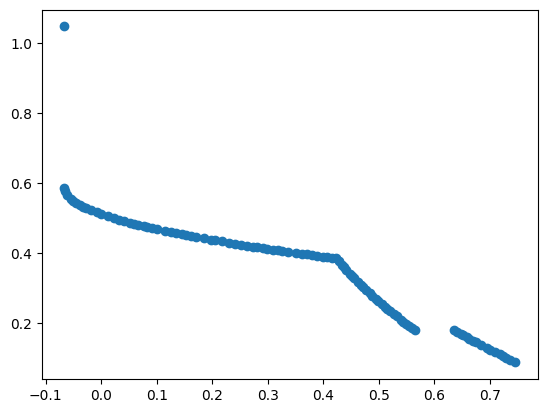

In [2]:
from pymoo.util.plotting import plot

# Plot the Pareto front
# Normally only test problems have access to the "real" Pareto front!
plot(problem.pareto_front())

## Solving an Analytical Problem with NSGA2

NSGA2 is a powerful evolutionary optimization algorithm. The algorithm as implemented in [pymoo](https://pymoo.org/) works well, however SBArchOpt adds several features on top to help with solving architecture optimization problems:
- Intermediate results storage and restart
- A repair operator that uses the architecture problem definition to automatically correct design points

To get a preconfigured NSGA2 algorithm, use the `get_nsga2` function. It can then be used like a normal pymoo algorithm to run an optimization.

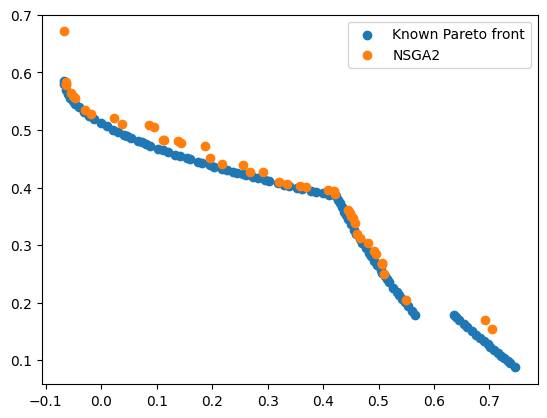

In [8]:
from pymoo.optimize import minimize
from sb_arch_opt.algo.pymoo_interface import get_nsga2

# Create the pre-configured NSGA2 algorithm
nsga2 = get_nsga2(pop_size=100)

# Run the optimization
result = minimize(problem, nsga2, termination=('n_gen', 20))

# Compare results
plot(problem.pareto_front(), result.opt.get('F'), labels=['Known Pareto front', 'NSGA2'])

### Restart and Intermediate Result Storage

Restart is very important when running expensive optimization studies, because if any problem happens you do not want to start from scratch (if the problem was not due to any bug in the evaluation code of course). Intermediate results storage can be useful for checking if generated results are correct and realistic while the algorithm is running.

To enable restart, we can use the `initialize_from_previous_results` folder. Restart also requires intermediate results storage, which can be activated by passing a `results_folder` when instantiating the algorithm.

In [12]:
import warnings
warnings.filterwarnings('ignore')

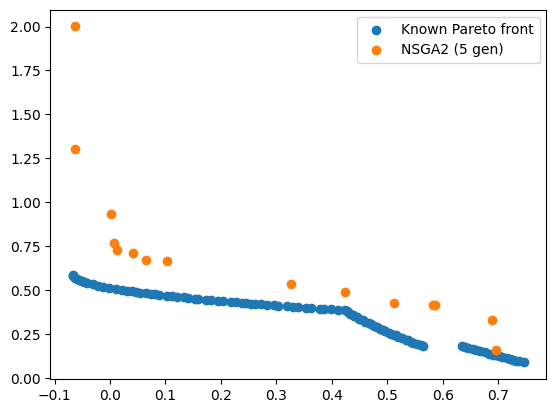

In [22]:
import tempfile

# We create a temporary folder for demonstration purposes
td = tempfile.TemporaryDirectory()
results_folder = td.name

# Create the algorithm with the results folder
nsga2 = get_nsga2(pop_size=100, results_folder=results_folder)

# Run for a few generations
result5 = minimize(problem, nsga2, termination=('n_gen', 5), copy_algorithm=False)

assert abs(nsga2.evaluator.n_eval - 500) < 10  # 5*100
plot(problem.pareto_front(), result5.opt.get('F'),
     labels=['Known Pareto front', 'NSGA2 (5 gen)'])

The results folder now contains some files that you can inspect:

In [24]:
import os
print(os.listdir(results_folder))

['pymoo_population.csv', 'pymoo_population.pkl', 'pymoo_population_cumulative.csv', 'pymoo_population_cumulative.pkl', 'pymoo_results.pkl']


INFO     2023-05-24 11:04:52,110 sb_arch_opt.pymoo : Previous results loaded from pymoo results: 500 design points
INFO     2023-05-24 11:04:52,110 sb_arch_opt.pymoo : Evaluation status: 500 of 500 (100.0%) are already evaluated


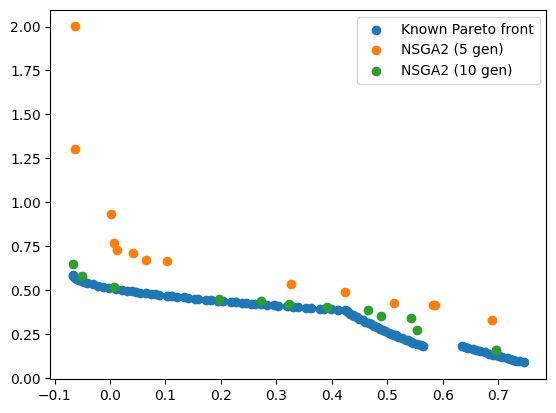

In [23]:
from sb_arch_opt.algo.pymoo_interface import initialize_from_previous_results

# Now create the algorithm again and initialize it from previously-generated results
nsga2 = get_nsga2(pop_size=100)
initialize_from_previous_results(nsga2, problem, results_folder)

# NOTE: normally you'd of course also pass the results folder here,
# but we omit it to prevent updating previous results in the notebook
# nsga2 = get_nsga2(pop_size=100, results_folder=results_folder)

# Previously-generated results count towards the evaluation budget,
# however not to the iteration ("generations") budget
result10 = minimize(problem, nsga2, termination=('n_gen', 6), copy_algorithm=False)

assert abs(nsga2.evaluator.n_eval - 1000) < 10  # 500 from previous + 5*100 continued optimization
plot(problem.pareto_front(), result5.opt.get('F'), result10.opt.get('F'),
     labels=['Known Pareto front', 'NSGA2 (5 gen)', 'NSGA2 (10 gen)'])

### Sampling an Architecture Design Space

If you only need to sample an architecture design space (i.e. not perform optimization), you can either use the `HierarchicalSampler` directly or use the DoE algorithm to also evaluate them, including restart and intermediate storage capabilities.

In [27]:
from sb_arch_opt.sampling import HierarchicalSampling

# Generate samples in the hierarchical architecture design space
pop = HierarchicalSampling().do(problem, n_samples=100)
x = pop.get('X')
x.shape

(100, 6)

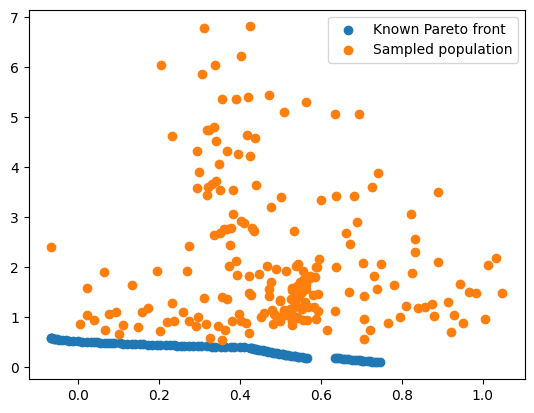

In [32]:
from sb_arch_opt.algo.pymoo_interface import get_doe_algo

# Create a new results folder
td.cleanup()
td = tempfile.TemporaryDirectory()
results_folder = td.name

# Create and run the DoE algorithm
doe_algo = get_doe_algo(doe_size=200, results_folder=results_folder)
result = minimize(problem, doe_algo)

plot(problem.pareto_front(), result.pop.get('F'), labels=['Known Pareto front', 'Sampled population'])

INFO     2023-05-24 11:14:09,879 sb_arch_opt.pymoo : Previous results loaded from pymoo results: 200 design points
INFO     2023-05-24 11:14:09,895 sb_arch_opt.pymoo : Evaluation status: 200 of 200 (100.0%) are already evaluated


1100


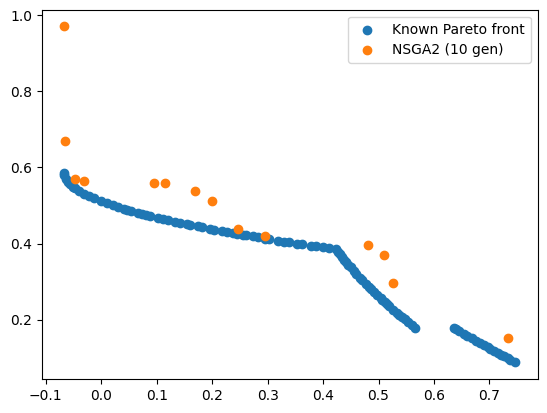

In [33]:
# Continue with an optimization from previous DoE results
nsga2 = get_nsga2(pop_size=100)
initialize_from_previous_results(nsga2, problem, results_folder)

result = minimize(problem, nsga2, termination=('n_gen', 10), copy_algorithm=False)

assert abs(nsga2.evaluator.n_eval - 1100) < 10  # 200 from DoE + 9*100 from optimization
plot(problem.pareto_front(), result.opt.get('F'), labels=['Known Pareto front', 'NSGA2 (10 gen)'])

In [ ]:
td.cleanup()

# Surrogate-Based Architecture Optimization

Surrogate-Based Optimization (SBO) is more useful for expensive problems as generally it requires less function evaluations to find a Pareto front.
SBArchOpt contains integrations for several SBO frameworks, however also comes with its own basic SBO algorithm that should be fine for most architecture optimization problems.

**Note**: make sure you have installed the `arch_sbo` dependencies:
```
pip install sb-arch-opt[arch_sbo]
```

In [34]:
td_sbo = tempfile.TemporaryDirectory()
results_folder = td_sbo.name

In [35]:
from sb_arch_opt.algo.arch_sbo import get_arch_sbo_gp

n_doe = 10
n_infill = 20

# Get SBO with a Gaussian Process model
sbo_algo = get_arch_sbo_gp(problem, init_size=n_doe, results_folder=results_folder)

result = minimize(problem, sbo_algo, termination=('n_eval', n_doe+n_infill))

INFO     2023-05-24 11:23:05,796 sb_arch_opt.sbo   : Surrogate infill gen 20 @ 2000 points evaluated (10 real unique, 10 eval)
INFO     2023-05-24 11:23:06,546 sb_arch_opt.sbo   : Surrogate infill gen 40 @ 4000 points evaluated (10 real unique, 10 eval)
INFO     2023-05-24 11:23:07,208 sb_arch_opt.sbo   : Infill: 1 new (eval 10 real unique, 10 eval)
INFO     2023-05-24 11:23:09,176 sb_arch_opt.sbo   : Surrogate infill gen 20 @ 2000 points evaluated (11 real unique, 11 eval)
INFO     2023-05-24 11:23:09,938 sb_arch_opt.sbo   : Surrogate infill gen 40 @ 4000 points evaluated (11 real unique, 11 eval)
INFO     2023-05-24 11:23:10,239 sb_arch_opt.sbo   : Infill: 1 new (eval 11 real unique, 11 eval)
INFO     2023-05-24 11:23:12,122 sb_arch_opt.sbo   : Infill: 1 new (eval 12 real unique, 12 eval)
INFO     2023-05-24 11:23:14,140 sb_arch_opt.sbo   : Surrogate infill gen 20 @ 2000 points evaluated (13 real unique, 13 eval)
INFO     2023-05-24 11:23:14,912 sb_arch_opt.sbo   : Surrogate infill g

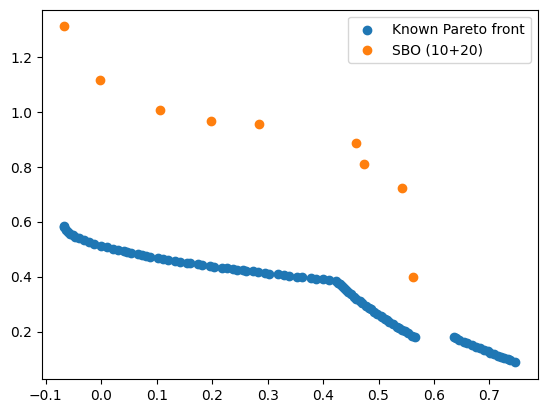

In [36]:
plot(problem.pareto_front(), result.opt.get('F'), labels=['Known Pareto front', 'SBO (10+20)'])

As can be seen, the results are not quite near the Pareto front yet.
Let's add some more infill points.

In [37]:
n_infill = 50
sbo_algo = get_arch_sbo_gp(problem, init_size=n_doe, results_folder=results_folder)
sbo_algo.initialize_from_previous_results(problem, results_folder)
result2 = minimize(problem, sbo_algo, termination=('n_eval', n_doe+n_infill))

INFO     2023-05-24 11:26:37,309 sb_arch_opt.pymoo : Previous results loaded from pymoo results: 30 design points
INFO     2023-05-24 11:26:37,309 sb_arch_opt.pymoo : Evaluation status: 30 of 30 (100.0%) are already evaluated
INFO     2023-05-24 11:26:40,050 sb_arch_opt.sbo   : Surrogate infill gen 20 @ 2000 points evaluated (30 real unique, 30 eval)
INFO     2023-05-24 11:26:41,073 sb_arch_opt.sbo   : Surrogate infill gen 40 @ 4000 points evaluated (30 real unique, 30 eval)
INFO     2023-05-24 11:26:41,233 sb_arch_opt.sbo   : Infill: 1 new (eval 30 real unique, 30 eval)
INFO     2023-05-24 11:26:43,781 sb_arch_opt.sbo   : Surrogate infill gen 20 @ 2000 points evaluated (31 real unique, 31 eval)
INFO     2023-05-24 11:26:44,553 sb_arch_opt.sbo   : Infill: 1 new (eval 31 real unique, 31 eval)
INFO     2023-05-24 11:26:47,131 sb_arch_opt.sbo   : Surrogate infill gen 20 @ 2000 points evaluated (32 real unique, 32 eval)
INFO     2023-05-24 11:26:48,182 sb_arch_opt.sbo   : Surrogate infill 

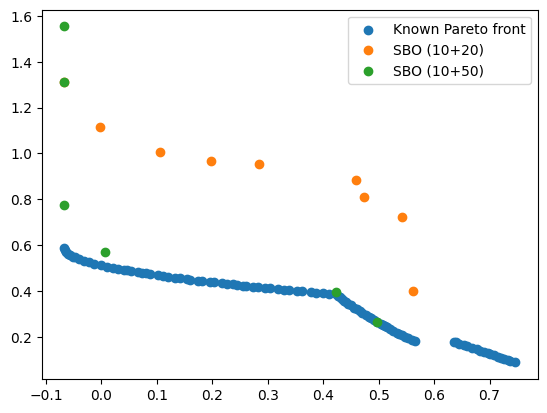

In [38]:
plot(problem.pareto_front(), result.opt.get('F'), result2.opt.get('F'), labels=['Known Pareto front', 'SBO (10+20)', 'SBO (10+50)'])

As you can see, already a good approximation of the Pareto front is achieved after only 60 evaluations, compared to 1000 evaluations for NSGA2 for a similar performance.

In [ ]:
td_sbo.cleanup()

# Implementing an Architecture Optimization Problem

Implementing a new architecture optimization problem is done by extending the `ArchOptProblemBase` class.
The hierarchical structure of the design space can be specified in two ways:
- **Implicitly** by implementing correction functions yourself
- **Explicitly** using a model of the hierarchical structure

Both are good options depending on what you want to achieve. If you already have some other code that implements design variable correcting then you can use the implicit method. If you are starting from scratch then the explicit method is recommended.

We demonstrate the different using the Jenatton test problem:
- 3 categorical variables: 0 or 1
- 6 continuous variables
- The categorical variables select which continuous variables are used for the calculation

We base our implementation on the one found in [Ax (BoTorch)](https://github.com/facebook/Ax/blob/main/ax/metrics/jenatton.py#L26).

In [46]:
import numpy as np
from pymoo.core.variable import Real, Choice
from sb_arch_opt.problem import ArchOptProblemBase


# Define the evaluation function
# You can clearly see the hierarchical structure
def jenatton_evaluate(x):
     if x[0] == 0:
          if x[1] == 0:
               return x[3]**3 + .1 + x[7]
          else:
               return x[4]**3 + .1 + x[7]
     else:
          if x[2] == 0:
               return x[5]**3 + .1 + x[8]
          else:
               return x[6]**3 + .1 + x[8]


class JenattonImplicit(ArchOptProblemBase):

     def __init__(self):
          # Define the design variables using pymoo variable classes
          des_vars = [
               Choice(options=[0, 1]), Choice(options=[0, 1]), Choice(options=[0, 1]),  # x1,2,3
               Real(bounds=[0, 1]), Real(bounds=[0, 1]), Real(bounds=[0, 1]),  # x4,5,6
               Real(bounds=[0, 1]), Real(bounds=[0, 1]), Real(bounds=[0, 1]),  # x7,8,9
          ]

          super().__init__(des_vars=des_vars)

     def _arch_evaluate(self, x: np.ndarray, is_active_out: np.ndarray, f_out: np.ndarray, g_out: np.ndarray,
                        h_out: np.ndarray, *args, **kwargs):
          """
          Implement evaluation and write results in the provided output matrices:
          - x (design vectors): discrete variables have integer values, imputed design vectors can be output here
          - is_active (activeness): vector specifying for each design variable whether it was active or not
          - f (objectives): written as a minimization
          - g (inequality constraints): written as "<= 0"
          - h (equality constraints): written as "= 0"
          """

          # Call the correction function to output which variables are inactive
          self._correct_x_impute(x, is_active_out)

          # Evaluate the design vectors
          for i, xi in enumerate(x):
               f_out[i, 0] = jenatton_evaluate(xi)

     def _correct_x(self, x: np.ndarray, is_active: np.ndarray):
          """Fill the activeness matrix and (if needed) impute any design variables that are partially inactive.
          Imputation of inactive design variables is always applied after this function."""

          # Start from everything inactive except the first variable
          is_active[:, 1:] = False

          # First branch
          branch1_1 = x[:, 0] == 0
          branch1_2 = x[:, 0] == 1

          is_active[branch1_1, 1] = True  # x2 and x8 are active in branch 1,1
          is_active[branch1_1, 7] = True
          is_active[branch1_2, 2] = True  # x3 and x9 are active in branch 1,2
          is_active[branch1_2, 8] = True

          # x1 and x2 branch
          branch2_1 = branch1_1 & (x[:, 1] == 0)
          branch2_2 = branch1_1 & (x[:, 1] == 1)
          branch2_3 = branch1_2 & (x[:, 2] == 0)
          branch2_4 = branch1_2 & (x[:, 2] == 1)

          is_active[branch2_1, 3] = True
          is_active[branch2_2, 4] = True
          is_active[branch2_3, 5] = True
          is_active[branch2_4, 6] = True

     def _is_conditionally_active(self):
          """Return for each design variable whether it is conditionally active (i.e. might become inactive). Not needed
          if an explicit design space is provided."""
          # Only the first variable never becomes inactive
          return [False if i == 0 else True for i in range(self.n_var)]

     def _get_n_active_cont_mean(self) -> int:
          """Get the mean number of active continuous dimensions, as seen over all discrete design vectors."""
          # Each of the four discrete branches has 2 active continuous variables
          return 2

     def _get_n_valid_discrete(self) -> int:
          """Return the number of valid discrete design points (ignoring continuous dimensions); enables calculation of
          the imputation ratio. Not needed if an explicit design space is provided."""
          return 4

     def __repr__(self):
          return f'{self.__class__.__name__}()'

JenattonImplicit().print_stats()

problem: JenattonImplicit()
n_discr: 3
n_cont : 6
n_obj  : 1
n_con  : 0
MD     : True
MO     : False
HIER         : True
n_valid_discr: 4
imp_ratio    : 6.00 (discrete: 2.00; continuous: 3.00)


In [55]:
result_impl = minimize(JenattonImplicit(), get_nsga2(pop_size=50), termination=('n_gen', 20))
print(f'Optimum: {result_impl.opt.get("F")}')
print(f'At X = {result_impl.opt.get("X")}')

Optimum: [[0.1000263]]
At X = [[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.04392382e-02
  5.00000000e-01 5.00000000e-01 5.00000000e-01 1.77627844e-05
  5.00000000e-01]]


The explicit design space definition uses the `ExplicitArchDesignSpace` class and a dedicated set of design variable definition classes.

Under the hood, it uses [ConfigSpace](https://automl.github.io/ConfigSpace/), so all its powerful condition and forbidden-clause modeling functionalities can be used.

In [56]:
from sb_arch_opt.design_space_explicit import *

class JenattonExplicit(ArchOptProblemBase):

     def __init__(self):
          # We define the hierarchical structure using the explicit design space class
          # The design variables are defined by
          ds = ExplicitArchDesignSpace([
               CategoricalParam('x1', [0, 1]),
               CategoricalParam('x2', [0, 1]),
               CategoricalParam('x3', [0, 1]),
               ContinuousParam('x4', 0, 1),
               ContinuousParam('x5', 0, 1),
               ContinuousParam('x6', 0, 1),
               ContinuousParam('x7', 0, 1),
               ContinuousParam('r8', 0, 1),
               ContinuousParam('r9', 0, 1),
          ])

          # Define activation conditions
          ds.add_conditions([
               # x2 and r8 are activated if x1 == 0
               EqualsCondition(ds['x2'], ds['x1'], 0),
               EqualsCondition(ds['r8'], ds['x1'], 0),

               # x4 and x5 are additionally only activated if x2 == 0 or 1, respectively
               EqualsCondition(ds['x4'], ds['x2'], 0),
               EqualsCondition(ds['x5'], ds['x2'], 1),

               # x1 == 1 activates x3, r9
               EqualsCondition(ds['x3'], ds['x1'], 1),
               EqualsCondition(ds['r9'], ds['x1'], 1),

               # x6 and x7 are additionally only activated if x3 == 0 or 1, respectively
               EqualsCondition(ds['x6'], ds['x3'], 0),
               EqualsCondition(ds['x7'], ds['x3'], 1),
          ])

          super().__init__(ds)

     def _arch_evaluate(self, x: np.ndarray, is_active_out: np.ndarray, f_out: np.ndarray, g_out: np.ndarray,
                        h_out: np.ndarray, *args, **kwargs):

          # No need to call the correction function, because the input is automatically
          # corrected according to the design space definition

          # Evaluate the design vectors
          for i, xi in enumerate(x):
               f_out[i, 0] = jenatton_evaluate(xi)

     def __repr__(self):
          return f'{self.__class__.__name__}()'

# Note how the problem definition is exactly the same as the implicit definition
JenattonExplicit().print_stats()

problem: JenattonExplicit()
n_discr: 3
n_cont : 6
n_obj  : 1
n_con  : 0
MD     : True
MO     : False
HIER         : True
n_valid_discr: 4
imp_ratio    : 6.00 (discrete: 2.00; continuous: 3.00)


In [59]:
result_expl = minimize(JenattonExplicit(), get_nsga2(pop_size=50), termination=('n_gen', 20))
print(f'Optimum: {result_expl.opt.get("F")}; implicit: {result_impl.opt.get("F")}; difference = {result_expl.opt.get("F")-result_impl.opt.get("F")}')
print(f'At X = {result_expl.opt.get("X")}')

Optimum: [[0.1007678]]; implicit: [[0.1000263]]; difference = [[0.0007415]]
At X = [[0.00000000e+00 1.00000000e+00 0.00000000e+00 5.00000000e-01
  5.24514449e-02 5.00000000e-01 5.00000000e-01 6.23497882e-04
  5.00000000e-01]]
